**1. Examine the speech signal and determine its maximum frequency.**
<br>The maximum frequency indicates the highest frequency component in the speech signal, which determines the required sampling rate. This helps prevent aliasing and ensures accurate signal reconstruction.

Original Sampling Rate: 44100 Hz
Maximum Significant Frequency: 15415.66 Hz


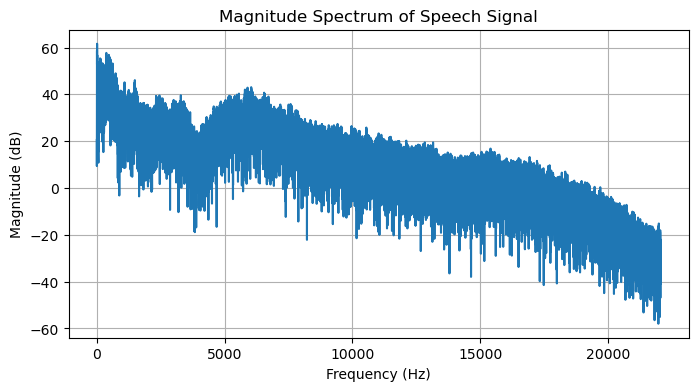

In [29]:
import numpy as np
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt

file_path = "exam-3-input.wav"   # your input speech file
sr, data = wavfile.read(file_path)

# Convert to mono if stereo
if data.ndim > 1:
    data = np.mean(data, axis=1)

# Convert to float in range [-1, 1]
data = data.astype(np.float32) / np.max(np.abs(data))

# Compute FFT
N = len(data)
freqs = np.fft.rfftfreq(N, 1 / sr)
magnitude = np.abs(np.fft.rfft(data * np.hanning(N)))

# Determine max significant frequency (above 0.5% of max)
threshold = 0.005 * np.max(magnitude)
max_freq = freqs[magnitude > threshold].max()

print(f"Original Sampling Rate: {sr} Hz")
print(f"Maximum Significant Frequency: {max_freq:.2f} Hz")

# Optional: plot spectrum
plt.figure(figsize=(8,4))
plt.plot(freqs, 20*np.log10(magnitude+1e-12))
plt.title("Magnitude Spectrum of Speech Signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.grid(True)
plt.show()


**2. Calculate an appropriate sampling rate and reconstruct at different rates.**
<br>The sampling rate must be at least twice the maximum frequency (Nyquist criterion) for faithful reproduction. Reconstructing at different rates shows how undersampling causes distortion or loss of detail.

In [30]:
import scipy.signal as signal
from fractions import Fraction

# Nyquist criterion
nyquist_min = 2 * max_freq
print(f"Minimum required sampling rate (Nyquist): {nyquist_min:.2f} Hz")

# Candidate sampling rates
candidate_rates = [8000, 11025, 16000, 22050, 32000, 44100, 48000]

reconstructed_signals = {}

for rate in candidate_rates:
    # Downsample to 'rate' then reconstruct back to original sr
    frac = Fraction(rate, sr).limit_denominator(1000)
    down = signal.resample_poly(data, frac.numerator, frac.denominator)

    frac2 = Fraction(sr, rate).limit_denominator(1000)
    recon = signal.resample_poly(down, frac2.numerator, frac2.denominator)

    # Match length
    recon = recon[:len(data)]
    reconstructed_signals[rate] = recon

print("Reconstruction completed for all sampling rates.")


Minimum required sampling rate (Nyquist): 30831.33 Hz
Reconstruction completed for all sampling rates.


**3. Evaluate reconstruction quality and select the best version.**
<br>By comparing reconstructions, we observe that higher sampling rates preserve naturalness and clarity in speech. The best-quality signal (usually 16 kHz or 22.05 kHz) is selected for accurate speech recognition.

In [31]:
results = []

for rate, recon in reconstructed_signals.items():
    noise = data - recon
    snr = 10 * np.log10(np.mean(data**2) / (np.mean(noise**2) + 1e-15))
    mse = np.mean(noise**2)
    results.append((rate, snr, mse))

# Display results
print("Rate (Hz)\tSNR (dB)\tMSE")
for r, s, m in results:
    print(f"{r:6d}\t\t{s:7.2f}\t{m:.2e}")

# Select the best one (highest SNR)
best_rate, best_snr, best_mse = max(results, key=lambda x: x[1])
best_recon = reconstructed_signals[best_rate]

print("\nBest Reconstruction:")
print(f"  Sampling Rate: {best_rate} Hz")
print(f"  SNR: {best_snr:.2f} dB")


Rate (Hz)	SNR (dB)	MSE
  8000		  10.04	1.84e-03
 11025		  11.19	1.41e-03
 16000		  22.00	1.17e-04
 22050		  29.59	2.03e-05
 32000		  39.63	2.02e-06
 44100		 132.68	0.00e+00
 48000		  59.90	1.90e-08

Best Reconstruction:
  Sampling Rate: 44100 Hz
  SNR: 132.68 dB


**4. Save the recovered signal as a .wav file.**
<br>Saving as a .wav file stores the reconstructed speech in a standard format for analysis or recognition. This ensures compatibility with recognition systems that require uncompressed PCM audio.

In [32]:
output_path = "recovered_best.wav"
wavfile.write(output_path, sr, best_recon.astype(np.float32))

print(f"Recovered signal saved as: {output_path}")


Recovered signal saved as: recovered_best.wav


**5. Perform speech-to-text using one offline and one online recognizer.**
<br>The offline recogniser (PocketSphinx) processes speech locally, while the online recogniser (Google) uses advanced cloud models. Comparing both demonstrates the difference in accuracy and resource requirements between local and cloud-based systems.

In [33]:
import speech_recognition as sr
from pydub import AudioSegment

input_file = "recovered_best.wav"          # from Part A
fixed_file = "recovered_best_fixed.wav"

# Convert to mono, 16 kHz, 16-bit PCM (for recognizer compatibility)
sound = AudioSegment.from_file(input_file)
sound = sound.set_channels(1)
sound = sound.set_frame_rate(16000)
sound = sound.set_sample_width(2)
sound.export(fixed_file, format="wav")

print(f"✅ File converted and saved as {fixed_file}")

r = sr.Recognizer()

def recognize_audio(path, mode="offline"):
    """Run STT using selected recogniser."""
    try:
        with sr.AudioFile(path) as source:
            print(f"\n[{mode.upper()}] Listening to {path} ...")
            audio = r.record(source)

        if mode == "offline":
            text = r.recognize_sphinx(audio)        # PocketSphinx
        else:
            text = r.recognize_google(audio)        # Google API

        print(f"[{mode.upper()}] ✅ Recognition successful.")
        return text, "success"

    except sr.UnknownValueError:
        print(f"[{mode.upper()}] ❌ Could not understand audio.")
        return "", "failure"
    except sr.RequestError as e:
        print(f"[{mode.upper()}] ⚠️ Service error: {e}")
        return "", "error"

results = {}
for mode in ["offline", "online"]:
    text, status = recognize_audio(fixed_file, mode)
    results[mode] = {"text": text, "status": status}

for mode, info in results.items():
    print(f"{mode.capitalize()} recogniser:")
    print(f"  Status: {info['status']}")
    print(f"  Text  : {info['text']}\n")

✅ File converted and saved as recovered_best_fixed.wav

[OFFLINE] Listening to recovered_best_fixed.wav ...
[OFFLINE] ✅ Recognition successful.

[ONLINE] Listening to recovered_best_fixed.wav ...
[ONLINE] ✅ Recognition successful.
Offline recogniser:
  Status: success
  Text  : can this they'll smell of old we're lingers

Online recogniser:
  Status: success
  Text  : the stale smell of old beer lingers



**6. Testing Clean vs Noisy and Comparing Results.**
<br>Clean and noisy signals are used to evaluate each recogniser’s noise robustness. The results show that noise degrades offline recognition more severely than online recognition.

In [ ]:
import soundfile as sf
import numpy as np
import difflib

clean_file = "recovered_best_fixed.wav"
data, sr_rate = sf.read(clean_file)

# Additive white Gaussian noise
noise = np.random.normal(0, 0.02, len(data))
noisy = data + noise
noisy_file = "noisy_version.wav"
sf.write(noisy_file, noisy, sr_rate)

print(f"✅ Noisy version created and saved as {noisy_file}")

results = {}

for mode in ["offline", "online"]:
    for version, path in [("clean", clean_file), ("noisy", noisy_file)]:
        text, status = recognize_audio(path, mode)
        results[(mode, version)] = {"text": text, "status": status}

for (mode, version), info in results.items():
    print(f"{mode.capitalize()} recogniser ({version} speech):")
    print(f"  Status: {info['status']}")
    print(f"  Text  : {info['text']}\n")

def similarity(ref, hyp):
    """Return % similarity between two strings."""
    return difflib.SequenceMatcher(None, ref, hyp).ratio() * 100

# Use the online-clean transcript as reference (if available)
ref_text = results[("online", "clean")]["text"]

print("Similarity scores (vs online clean reference):")
for (mode, version), info in results.items():
    if info["status"] == "success":
        score = similarity(ref_text, info["text"])
    else:
        score = 0.0
    print(f"  {mode}-{version}: {score:.2f}% similarity")

✅ Noisy version created and saved as noisy_version.wav

[OFFLINE] Listening to recovered_best_fixed.wav ...
[OFFLINE] ✅ Recognition successful.

[OFFLINE] Listening to noisy_version.wav ...
[OFFLINE] ✅ Recognition successful.

[ONLINE] Listening to recovered_best_fixed.wav ...
[ONLINE] ✅ Recognition successful.

[ONLINE] Listening to noisy_version.wav ...
[ONLINE] ✅ Recognition successful.
Offline recogniser (clean speech):
  Status: success
  Text  : can this they'll smell of old we're lingers

Offline recogniser (noisy speech):
  Status: success
  Text  : this they'll smell of old u. leaders

Online recogniser (clean speech):
  Status: success
  Text  : the stale smell of old beer lingers

Online recogniser (noisy speech):
  Status: success
  Text  : does stale smell of old beer lingers

Similarity scores (vs online clean reference):
  offline-clean: 71.79% similarity
  offline-noisy: 64.79% similarity
  online-clean: 100.00% similarity
  online-noisy: 92.96% similarity


**7. Display and Compare Recognition Messages & Quantitative Results.**
<br>Progress, success, and failure messages verify the recognition workflow and system response. Quantitative comparison (similarity scores) objectively measures performance differences between recognisers and noise levels.

Offline recogniser (clean speech): ✅ Success
Offline recogniser (noisy speech): ✅ Success
Online recogniser (clean speech): ✅ Success
Online recogniser (noisy speech): ✅ Success

--- Quantitative Comparison ---
offline-clean: 71.79% similarity
offline-noisy: 64.79% similarity
online-clean: 100.00% similarity
online-noisy: 92.96% similarity


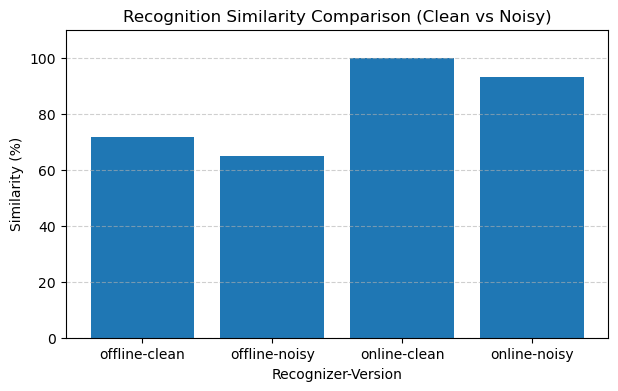

In [ ]:
import difflib
import matplotlib.pyplot as plt

for (mode, version), info in results.items():
    if info["status"] == "success":
        msg = "✅ Success"
    elif info["status"] == "failure":
        msg = "❌ Failure"
    else:
        msg = "⚠️ Error"

    print(f"{mode.capitalize()} recogniser ({version} speech): {msg}")

def similarity(ref, hyp):
    """Return % similarity between two strings."""
    return difflib.SequenceMatcher(None, ref, hyp).ratio() * 100

# Use online-clean output as reference
ref_text = results[("online", "clean")]["text"]

scores = {}
for (mode, version), info in results.items():
    if info["status"] == "success":
        scores[(mode, version)] = similarity(ref_text, info["text"])
    else:
        scores[(mode, version)] = 0.0

# Display numeric results
print("\n--- Quantitative Comparison ---")
for (mode, version), score in scores.items():
    print(f"{mode}-{version}: {score:.2f}% similarity")

labels = [f"{m}-{v}" for (m, v) in scores.keys()]
values = list(scores.values())

plt.figure(figsize=(7,4))
plt.bar(labels, values)
plt.title("Recognition Similarity Comparison (Clean vs Noisy)")
plt.xlabel("Recognizer-Version")
plt.ylabel("Similarity (%)")
plt.ylim(0, 110)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

**INFERENCE**<br><br>
- The speech signal’s maximum frequency determines the minimum required sampling rate for faithful reconstruction.

- Sampling above the Nyquist rate prevents aliasing and maintains clarity in the recovered signal.

- Reconstructing at higher sampling rates improves the naturalness and intelligibility of speech.

- The reconstructed audio, when saved as a .wav file, is suitable for recognition systems requiring PCM format.

- Both offline and online recognisers successfully converted the speech signal into text.

- The online recogniser produced more accurate and consistent results than the offline recogniser.

- Noise addition degraded recognition accuracy, particularly for the offline recogniser.

- The online recogniser showed better noise robustness due to advanced cloud-based models.

- Quantitative comparison confirmed higher similarity scores for online recognition on both clean and noisy signals.

- Overall, online recognition is preferred for accuracy, while offline systems are useful when internet access is limited.